In [1]:
from tst.domutil.util import *
from tst.domutil.test import *

/export/people/zcbtfge/Documents/repos/test_envs/django_CATH/local/lib/python2.7/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)
/export/people/zcbtfge/Documents/repos/test_envs/django_CATH/local/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [3]:
import sys
reload(sys.modules["tst.domutil.util"])
from tst.domutil.util import *

In [2]:
%%time
# print "finished"
hmms = HMMprofile.objects.defer('text').all().prefetch_related('hits')
hmms = hmms.annotate(hcount = Count('hits')).order_by('id')

hmmids = list(hmms.values_list('id',flat = True))
hcounts = list(hmms.values_list('hcount',flat = True))
sfs = list(hmms.values_list('cath_node__parent',flat = True))

sDB = seqDB.objects.get(name = 'CATH')
sDB.sequence_set.count()
seq = sDB.sequence_set.first()

seqset_all = sDB.sequence_set.all().prefetch_related('hmmprofile_set')

# seq.HMMprofile
# seq.hmmprofile
# dir(seq)
seq.hmmprofile_set.count()

# hcounts_pad = hcounts_
hmmids_pad = hmmids[:]
hmmids_pad.insert(0, None)

hcounts_pad = hcounts[:]
hcounts_pad.insert(0,None)

sfs_pad = sfs[:]
sfs_pad.insert(0,None)


CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 44.4 s


In [4]:
%%time 
D_raw = pk_load('D_raw')
D_norm = pk_load('D_norm')

test__raw(D_raw,hmms)
test__norm(D_norm,hmms)

[OK] HMM for 3.20.20.70.102.0  against HMM for 3.40.50.80.20.0  overlaps 1, with 1 from 
0 of -1
[OK] HMM for 3.40.50.720.379.0  against HMM for 3.40.50.720.491.0  overlaps 3, with 3 from 
[OK] HMM for 3.40.50.300.138.0  against HMM for 3.40.50.2300.249.0  overlaps 9, with 9 from 
[OK] HMM for 3.40.190.10.284.0  against HMM for 3.40.190.10.186.0  overlaps 1, with 1 from 
[OK] HMM for 3.40.50.1820.101.0  against HMM for 3.90.1820.10.1.0  overlaps 1, with 1 from 
[OK] HMM for 3.20.20.70.102.0  against HMM for 3.40.50.80.20.0  overlaps:: Expected:2.18220044462, Actual:2.18220044462
0 of -1
[OK] HMM for 3.40.50.720.379.0  against HMM for 3.40.50.720.491.0  overlaps:: Expected:2.0438707496, Actual:2.0438707496
[OK] HMM for 3.40.50.300.138.0  against HMM for 3.40.50.2300.249.0  overlaps:: Expected:1.57284676195, Actual:1.57284676195
[OK] HMM for 3.40.190.10.284.0  against HMM for 3.40.190.10.186.0  overlaps:: Expected:1.87679152945, Actual:1.87679152945
[OK] HMM for 3.40.50.1820.101.0  again

In [25]:
%%time
##################################################################
##################################################################
############### Append information to pairwise hits   ############
################Short version ####################################
##################################################################

# using_coo_izip
# D_curr = D_raw
D_curr = D_norm

xdata = []
ydata = []
vdata = []
sfbools = []

for x,y,v in using_tocoo_izip(D_curr):
    xdata.append( hcounts_pad[x])
    ydata.append( hcounts_pad[y])
    vdata.append( v )
    
    sfbools.append(sfs_pad[x]==sfs_pad[y])

CPU times: user 4.38 s, sys: 120 ms, total: 4.5 s
Wall time: 4.5 s


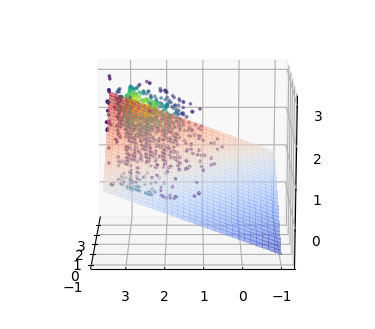

In [23]:
#####################################################################
################ Plotting using D_norm matrix ######################
#####################################################################
#####################################################################


from scipy import stats
import matplotlib
%matplotlib inline
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

kwargs = {
    'projection':'3d',
}
plt.close()
siz = [450,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)
# idx = range(1000)


N = 1000

xss = np.array(xdata)
yss = np.array(ydata)
zss = np.array(vdata)

# xss = np.array(xss)
# yss = np.array(yss) 
# zss = np.array(zss)

# idx = sfbools
# xss = np.delete(xss,idx)
# yss = np.delete(yss,idx)
# zss = np.delete(zss,idx)

idx = np.random.choice(range(len(xss)), N, replace = False)
xss= np.array(xss)
yss = np.array(yss)
zss = np.array(zss)


xss = xss[idx]
yss = yss[idx]
zss = zss[idx]
# xss= np.array(xss[:N])
# yss = np.array(yss[:N])
# zss = np.array(zss[:N])

xss = np.log10(xss + 1)
yss = np.log10(yss + 1)
# zss = np.log10(zss+1)

xyz = np.vstack([xss,yss,zss])
kde = stats.gaussian_kde(xyz)
# ax1.set_zlim([0,2000])

ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))

X = np.linspace(xss.min(), xss.max(),30)
Y = np.linspace(yss.min(), yss.max(),30)
X = np.linspace( -1 , xss.max(),30)
Y = np.linspace( -1 , yss.max(),30)
# Z = np.linspace(zss.min(), zss.max(),30)
# Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = (X + Y) / 2.9 

ax1.view_init(elev=15., azim=180)
surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha = 0.5, 
                       linewidth=0, antialiased=False)

In [11]:
import sys
reload(sys.modules["matplotlib"])
# from tst.domutil.util import *

/export/people/zcbtfge/Documents/repos/test_envs/django_CATH/local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'matplotlib' from '/export/people/zcbtfge/Documents/repos/test_envs/django_CATH/local/lib/python2.7/site-packages/matplotlib/__init__.pyc'>

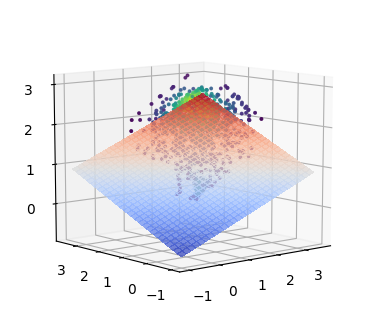

In [24]:
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)

def init():
#     ax1 = fig.add_subplot(111,**kwargs)
    pts = ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))# for angle in range(0, 360):
    surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha = 0.5, 
                       linewidth=0, antialiased=False)
    return (fig,)


def animate(i):
#     angle = i*0.5
#     pts = ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))# for angle in range(0, 360):
#     ax1.view_init(30, angle
    ax1.view_init(elev=10., azim=i*10)
#     plt.draw()
#     plt.pause(.001)
    return (fig,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=60, interval=200, blit=True);
HTML(anim.to_html5_video())

In [ ]:
%%time
##################################################################
##################################################################
############### Append information to pairwise hits   ############
################Short version ####################################
##################################################################

# using_coo_izip
D_curr = D_raw
# D_curr = D_norm

xdata = []
ydata = []
vdata = []
sfbools = []

for x,y,v in using_tocoo_izip(D_curr):
    xdata.append( hcounts_pad[x])
    ydata.append( hcounts_pad[y])
    vdata.append( v )
    
    sfbools.append(sfs_pad[x]==sfs_pad[y])

(<matplotlib.figure.Figure at 0x7f5047d322d0>,)

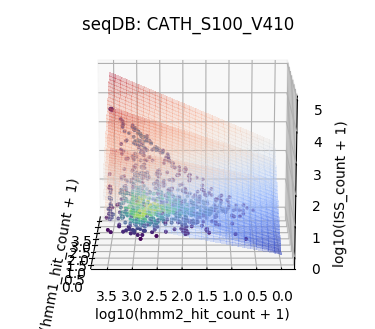

In [49]:
#####################################################################
################ Plotting using D_raw matrix ########################
#####################################################################
#####################################################################

from scipy import stats
import matplotlib
%matplotlib inline
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

kwargs = {
    'projection':'3d',
    'zlabel':'log10(ISS_count + 1)' , 
    'xlabel':'log10(hmm1_hit_count + 1)' ,
    'ylabel':'log10(hmm2_hit_count + 1)' ,
    'title' :'seqDB: CATH_S100_V410'
}
plt.close()
siz = [450,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)
# idx = range(1000)


N = 1000

xss = np.array(xdata)
yss = np.array(ydata)
zss = np.array(vdata)

idx = np.random.choice(range(len(xss)), N, replace = False)
xss= np.array(xss)
yss = np.array(yss)
zss = np.array(zss)


xss = xss[idx]
yss = yss[idx]
zss = zss[idx]

xss = np.log10(xss + 1)
yss = np.log10(yss + 1)
zss = np.log10(zss+1)

xyz = np.vstack([xss,yss,zss])
kde = stats.gaussian_kde(xyz)
# ax1.set_zlim([0,2000])

ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))

X = np.linspace(xss.min(), xss.max(),30)
Y = np.linspace(yss.min(), yss.max(),30)
X = np.linspace( -0 , xss.max(),30)
Y = np.linspace( -0 , yss.max(),30)
# Z = np.linspace(zss.min(), zss.max(),30)
# Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z1 = (X + Y) / 1.5 
Z2 = (X + Y) / 2. 
Z3 = (X + Y) / 3.3 

ax1.view_init(elev=15., azim=180)

def init():
#     ax1 = fig.add_subplot(111,**kwargs)
    pts = ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))# for angle in range(0, 360):
#     surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha = 0.5, 
#                        linewidth=0, antialiased=False)
    surf = ax1.plot_surface(X, Y, Z1, cmap=cm.coolwarm, alpha = 0.25, 
                           linewidth=0, antialiased=False)
    surf = ax1.plot_surface(X, Y, Z2, cmap=cm.coolwarm, alpha = 0.25, 
                           linewidth=0, antialiased=False)
    surf = ax1.plot_surface(X, Y, Z3, cmap=cm.coolwarm, alpha = 0.25, 
                           linewidth=0, antialiased=False)
    return (fig,)
init()

CPU times: user 1min 35s, sys: 560 ms, total: 1min 36s
Wall time: 1min 54s


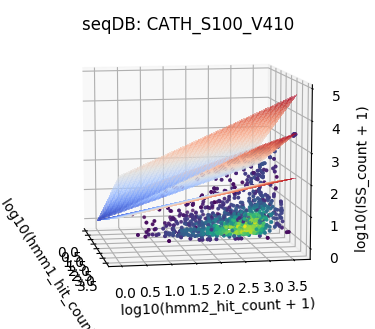

In [50]:
%%time
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)

# def init():
# #     ax1 = fig.add_subplot(111,**kwargs)
#     pts = ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))# for angle in range(0, 360):
#     surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha = 0.5, 
#                        linewidth=0, antialiased=False)
#     return (fig,)


def animate(i):
#     angle = i*0.5
#     pts = ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))# for angle in range(0, 360):
#     ax1.view_init(30, angle
    ax1.view_init(elev=10., azim=i*10)
#     plt.draw()
#     plt.pause(.001)
    return (fig,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=144, interval=200, blit=True);

# HTML(anim.to_html5_video())


anim.save( 'tst/mov/sliced_CATH410_raw.gif',writer='imagemagick')

In [48]:
anim.save( 'tst/mov/sliced_CATH410_raw.mp4',writer='ffmpeg',fps=10)

In [ ]:
%%time
##################################################################
##################################################################
############### Append information to pairwise hits   ############
################Short version ####################################
##################################################################

# using_coo_izip
D_curr = D_raw
# D_curr = D_norm

xdata = []
ydata = []
vdata = []
sfbools = []

for x,y,v in using_tocoo_izip(D_curr):
    xdata.append( hcounts_pad[x])
    ydata.append( hcounts_pad[y])
    vdata.append( v )
    
    sfbools.append(sfs_pad[x]==sfs_pad[y])

(<matplotlib.figure.Figure at 0x7f505d460f10>,)

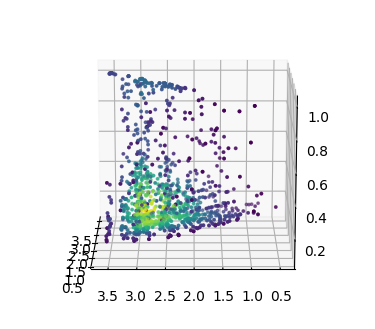

In [42]:
#####################################################################
################ Plotting using D_raw matrix ########################
#####################################################################
#####################################################################

from scipy import stats
import matplotlib
%matplotlib inline
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

kwargs = {
    'projection':'3d',
}
plt.close()
siz = [450,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)
# idx = range(1000)


N = 1000

xss = np.array(xdata)
yss = np.array(ydata)
zss = np.array(vdata)

idx = np.random.choice(range(len(xss)), N, replace = False)
xss= np.array(xss)
yss = np.array(yss)
zss = np.array(zss)


xss = xss[idx]
yss = yss[idx]
zss = zss[idx]

xss = np.log10(xss + 1)
yss = np.log10(yss + 1)
zss = 2 * np.log10(zss + 1) / (xss + yss)

xyz = np.vstack([xss,yss,zss])
kde = stats.gaussian_kde(xyz)
# ax1.set_zlim([0,2000])

ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))

X = np.linspace(xss.min(), xss.max(),30)
Y = np.linspace(yss.min(), yss.max(),30)
X = np.linspace( -0 , xss.max(),30)
Y = np.linspace( -0 , yss.max(),30)
# Z = np.linspace(zss.min(), zss.max(),30)
# Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
# Z1 = (X + Y) / 1.5 
# Z2 = (X + Y) / 2. 
# Z3 = (X + Y) / 3.3 

ax1.view_init(elev=15., azim=180)

def init():
#     ax1 = fig.add_subplot(111,**kwargs)
    pts = ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))# for angle in range(0, 360):
#     surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha = 0.5, 
#                        linewidth=0, antialiased=False)
#     surf = ax1.plot_surface(X, Y, Z1, cmap=cm.coolwarm, alpha = 0.5, 
#                            linewidth=0, antialiased=False)
#     surf = ax1.plot_surface(X, Y, Z2, cmap=cm.coolwarm, alpha = 0.5, 
#                            linewidth=0, antialiased=False)
#     surf = ax1.plot_surface(X, Y, Z3, cmap=cm.coolwarm, alpha = 0.5, 
#                            linewidth=0, antialiased=False)
    return (fig,)
init()

CPU times: user 120 ms, sys: 144 ms, total: 264 ms
Wall time: 109 ms


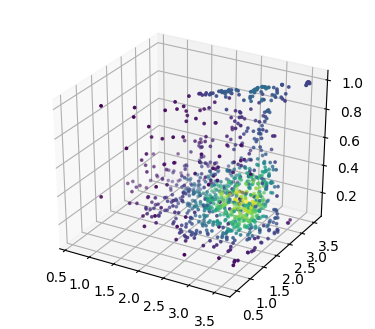

In [43]:
%%time
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)

def animate(i):
    ax1.view_init(elev=10., azim=i*10)
    return (fig,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=60, interval=200, blit=True);
HTML(anim.to_html5_video())


In [ ]:
anim.save(fname + '.mov')